# **Applying Quantum Autoencoders for Time Series Anomaly Detection**


A remake of the autoencoder proposed in the article "Applying Quantum Autoencoders for Time Series Anomaly Detection", published 10/10/2024, by Robin Frehner, Kurt Stockinger.

Dataset avaliable here: https://www.cs.ucr.edu/~eamonn/time_series_data_2018/ upload it on your Google Drive to make the code work.

# Environment set up and Imports

In [1]:
pip install torch pandas numpy pennylane pennylane-lightning redis matplotlib tqdm scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.9 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Dataset preparation
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride):
        self.data = self.create_sliding_windows(data, window_size, stride)

    def create_sliding_windows(self, data, window_size, stride):
        windows = []
        for i in range(0, len(data) - window_size + 1, stride):
            windows.append(data[i:i + window_size])
        return np.array(windows)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [5]:
# Quantum Encoder circuit with Amplitude Encoding
def get_quantum_node(num_qubits, dev):
    def quantum_circuit(inputs, weights):

        # Amplitude Encoding
        qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), pad_with=0, normalize=True)


        # #select all and pressctrl ù to comment
        # #QUASI AMPLITUDE ENCODING (alternative useful for real quantum hardware)

        # qml.RY(0.578, wires=0)  #(ANGLE_OF_ROTATION, wires=QUBIT_TO_ROTATE)
        # qml.RY(0.224, wires=1)
        # qml.RY(0.387, wires=2)
        # qml.RY(0.204, wires=3)
        # qml.RY(0.210, wires=4)
        # qml.RY(0.367, wires=5)
        # qml.RY(0.780, wires=6)

        # qml.RZ(0.101, wires=0)
        # qml.RZ(0.337, wires=1)
        # qml.RZ(0.430, wires=2)
        # qml.RZ(0.501, wires=3)
        # qml.RZ(0.215, wires=4)
        # qml.RZ(0.933, wires=5)
        # qml.RZ(0.169, wires=6)

        # qml.CNOT(wires=[6, 0])  #(wires=[CONTROL, TARGET])
        # qml.CNOT(wires=[0, 1])
        # qml.CNOT(wires=[1, 2])
        # qml.CNOT(wires=[2, 3])
        # qml.CNOT(wires=[3, 4])
        # qml.CNOT(wires=[4, 5])
        # qml.CNOT(wires=[5, 6])

        # qml.RY(0.406, wires=0)
        # qml.RY(0.118, wires=1)
        # qml.RY(0.366, wires=2)
        # qml.RY(0.232, wires=3)
        # qml.RY(0.816, wires=4)
        # qml.RY(0.696, wires=5)
        # qml.RY(0.353, wires=6)

        # qml.RZ(0.699, wires=0)
        # qml.RZ(0.887, wires=1)
        # qml.RZ(0.0979, wires=2)
        # qml.RZ(0.0109, wires=3)
        # qml.RZ(0.145, wires=4)
        # qml.RZ(0.224, wires=5)
        # qml.RZ(0.670, wires=6)

        # qml.CNOT(wires=[6, 5])
        # qml.CNOT(wires=[0, 6])
        # qml.CNOT(wires=[1, 0])
        # qml.CNOT(wires=[2, 1])
        # qml.CNOT(wires=[3, 2])
        # qml.CNOT(wires=[4, 3])
        # qml.CNOT(wires=[5, 4])

        # qml.RY(0.289, wires=0)
        # qml.RY(0.577, wires=1)
        # qml.RY(0.990, wires=2)
        # qml.RY(0.028, wires=3)
        # qml.RY(0.0959, wires=4)
        # qml.RY(0.953, wires=5)
        # qml.RY(0.194, wires=6)

        # qml.RZ(0.832, wires=0)
        # qml.RZ(0.788, wires=1)
        # qml.RZ(0.0319, wires=2)
        # qml.RZ(0.496, wires=3)
        # qml.RZ(0.228, wires=4)
        # qml.RZ(0.0255, wires=5)
        # qml.RZ(0.980, wires=6)


        # TRAINABLE ENCODER (variational gates) "PauliTwoDesign with two repetitions"

        qml.RY(np.pi/4, wires=0)
        qml.RY(np.pi/4, wires=1)
        qml.RY(np.pi/4, wires=2)
        qml.RY(np.pi/4, wires=3)
        qml.RY(np.pi/4, wires=4)
        qml.RY(np.pi/4, wires=5)
        qml.RY(np.pi/4, wires=6)

        qml.RZ(weights[0], wires=0)
        qml.RY(weights[1], wires=1)
        qml.RX(weights[2], wires=2)
        qml.RY(weights[3], wires=3)
        qml.RZ(weights[4], wires=4)
        qml.RX(weights[5], wires=5)
        qml.RX(weights[6], wires=6)

        qml.CZ(wires=[0, 1])
        qml.CZ(wires=[1, 2])
        qml.CZ(wires=[2, 3])
        qml.CZ(wires=[3, 4])
        qml.CZ(wires=[4, 5])
        qml.CZ(wires=[5, 6])

        qml.RY(weights[7], wires=0)
        qml.RZ(weights[8], wires=1)
        qml.RX(weights[9], wires=2)
        qml.RZ(weights[10], wires=3)
        qml.RX(weights[11], wires=4)
        qml.RX(weights[12], wires=5)
        qml.RX(weights[13], wires=6)

        qml.CZ(wires=[0, 1])
        qml.CZ(wires=[1, 2])
        qml.CZ(wires=[2, 3])
        qml.CZ(wires=[3, 4])
        qml.CZ(wires=[4, 5])
        qml.CZ(wires=[5, 6])

        qml.RX(weights[14], wires=0)
        qml.RX(weights[15], wires=1)
        qml.RY(weights[16], wires=2)
        qml.RY(weights[17], wires=3)
        qml.RX(weights[18], wires=4)
        qml.RY(weights[19], wires=5)
        qml.RY(weights[20], wires=6)

        # SWAP-TEST which measures how well the encoder circuit encodes the quasi-encoded input data

        qml.Hadamard(wires=8)
        qml.CSWAP(wires=[8, 6, 7])
        qml.Hadamard(wires=8)


        return qml.probs(wires=7)

    return quantum_circuit

In [6]:
# Quantum Encoder integration in PyTorch model
class QuantumEncoder(nn.Module):
    def __init__(self, num_qubits):
        super(QuantumEncoder, self).__init__()
        self.num_qubits = num_qubits
        self.dev = qml.device("lightning.qubit", wires=num_qubits + 2, shots=1024)
        self.weights = nn.Parameter(torch.rand(63) * np.pi)
        self.qnode = qml.QNode(get_quantum_node(num_qubits, self.dev), self.dev)

    def forward(self, x):
        x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize input
        swap_test_probs = []
        for window in x:
          probs = self.qnode(window, self.weights)
          prob_1 = probs[1]
          swap_test_probs.append(prob_1)

        return torch.stack(swap_test_probs) # Use torch.stack to keep the computational graph

In [7]:
# Data preparation
train_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TRAIN.tsv'
test_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TEST.tsv'

def load_data(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None)
    data = data.iloc[:, 1:]  # Remove the first column
    return data.values.flatten()

train_data = load_data(train_file_path)
test_data = load_data(test_file_path)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()

# Create sliding windows
window_size = 128
stride = 1
train_dataset = TimeSeriesDataset(train_data, window_size, stride)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



In [8]:
# Train the Quantum Encoder
num_qubits = 7
encoder = QuantumEncoder(num_qubits)

# Training Loop
epochs = 1
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
from tqdm import tqdm
import copy

best_loss = float('inf')
patience = 10
trigger_times = 0
best_encoder = None

for epoch in range(epochs):
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
    for i, batch in progress_bar:
        optimizer.zero_grad()
        # Get the probability of measuring |1> on qubit 8, which is the swap test result
        swap_test_results = encoder(batch)
        # Loss is the probability of measuring |1>
        loss = torch.mean(swap_test_results)
        # We want to minimize the probability of measuring |1>, so that qubits 6 and 7 are as similar as possible
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()}) # Add loss to the progress bar

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Avg. Loss: {avg_epoch_loss}")

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_encoder = copy.deepcopy(encoder)
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1} since the loss did not improve for {patience} epochs')
            break

if best_encoder is not None:
  print("Loading best model")
  encoder = best_encoder

Epoch 1/1: 100%|██████████| 5057/5057 [2:18:06<00:00,  1.64s/it, loss=0]

Epoch 1/1, Avg. Loss: 0.011150206976406467


TypeError: cannot pickle 'pennylane_lightning.lightning_qubit_ops.StateVectorC128' object

Processing Test Samples: 100%|██████████| 80898/80898 [10:45<00:00, 125.26it/s]


Detected anomalies at indices: []


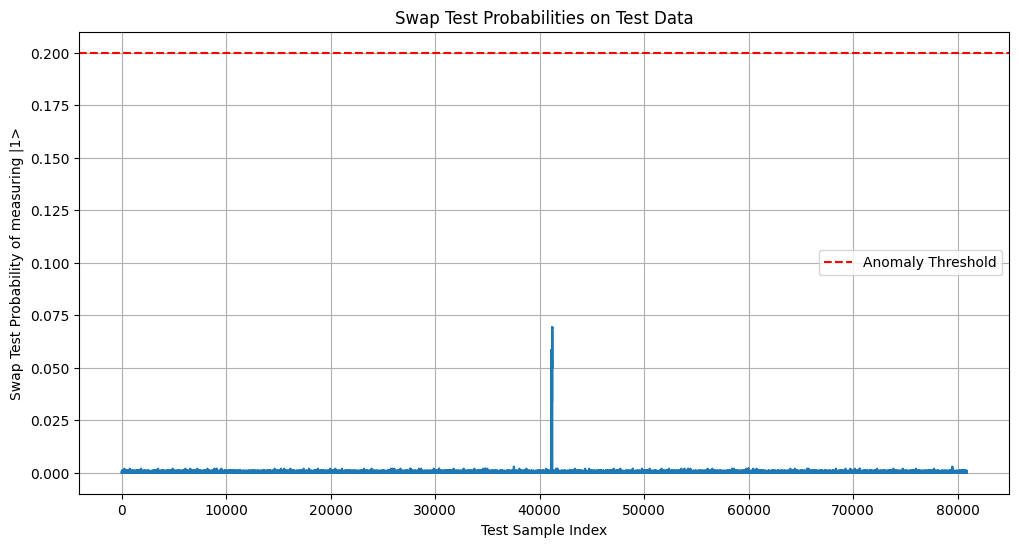

In [10]:
# Anomaly Detection
from tqdm import tqdm

stride = 1
test_dataset = TimeSeriesDataset(test_data, window_size, stride)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

anomalies = []
threshold = 0.01  # Threshold for considering the states different
normal_probs = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Test Samples")

for i, test_sample in progress_bar:
    prob_1 = encoder(test_sample).item()
    normal_probs.append(prob_1)
    if prob_1 > threshold:  # Corrected: Check if prob_1 is above threshold
        anomalies.append(i)

print(f"Detected anomalies at indices: {anomalies}")



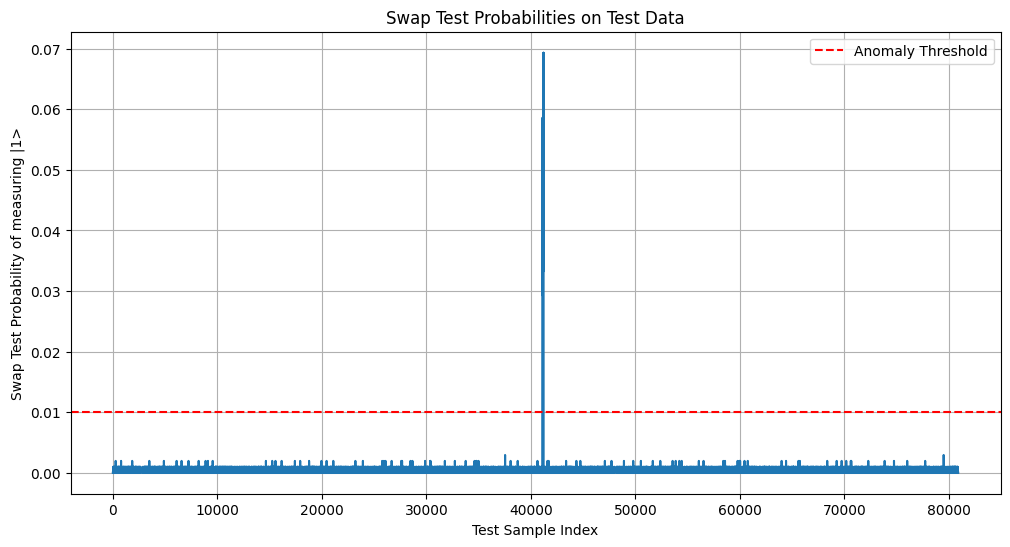

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(normal_probs)
plt.xlabel('Test Sample Index')
plt.ylabel('Swap Test Probability of measuring |1>')
plt.title('Swap Test Probabilities on Test Data')
plt.axhline(y=0.01, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.grid(True)
plt.show()